In [1]:
import os
import sys
sys.path.append('/Users/david/Desktop/FinetuneEmbed')
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Specify the working directory
os.chdir('/Users/david/Desktop/FinetuneEmbed')
# os.chdir('/afs/crc.nd.edu/group/StatDataMine/dm011/Dailin_Gan/FinetuneEmbed')
llm_ls = [# 'GenePT_1536',
          'GIST-small-Embedding-v0',
          'NoInstruct-small-Embedding-v0',
          'stella-base-en-v2',
          'e5-small-v2',
          'GIST-all-MiniLM-L6-v2',
          'gte-small',
          'bge-small-en-v1.5',
          'MedEmbed-small-v0.1',
          'gte-tiny',
          'e5-small',
          # "biobert-base-cased-v1.1"
          ]
random_states = list(range(41, 51)) # set up the random seeds
task_ls = ['LongShortTF', 'Sensitivity', 'BivalentLys4',
           'BivalentNoMethyl']

root = './res/2025_0528_finetune_11SLLMs_4tasks'
embed_type = 'Gene_Name'
fig_num = "Fig6"


In [2]:
all_model_runs = {}
for task in task_ls:
    task_dict = {}
    for llm in llm_ls:
        runs = []
        for state in random_states:
            res_path = f"{root}/{embed_type}/{llm}/{task}/ROC_curve_{state}.pkl"
            with open(res_path, 'rb') as f:
                    run = pickle.load(f)
            runs.append(run)
        task_dict[llm] = runs
    if task == 'LongShortTF':
        all_model_runs['Task_1'] = task_dict
    elif task == 'Sensitivity':
        all_model_runs['Task_2'] = task_dict
    elif task == 'BivalentLys4':
        all_model_runs['Task_3'] = task_dict
    elif task == 'BivalentNoMethyl':
        all_model_runs['Task_4'] = task_dict

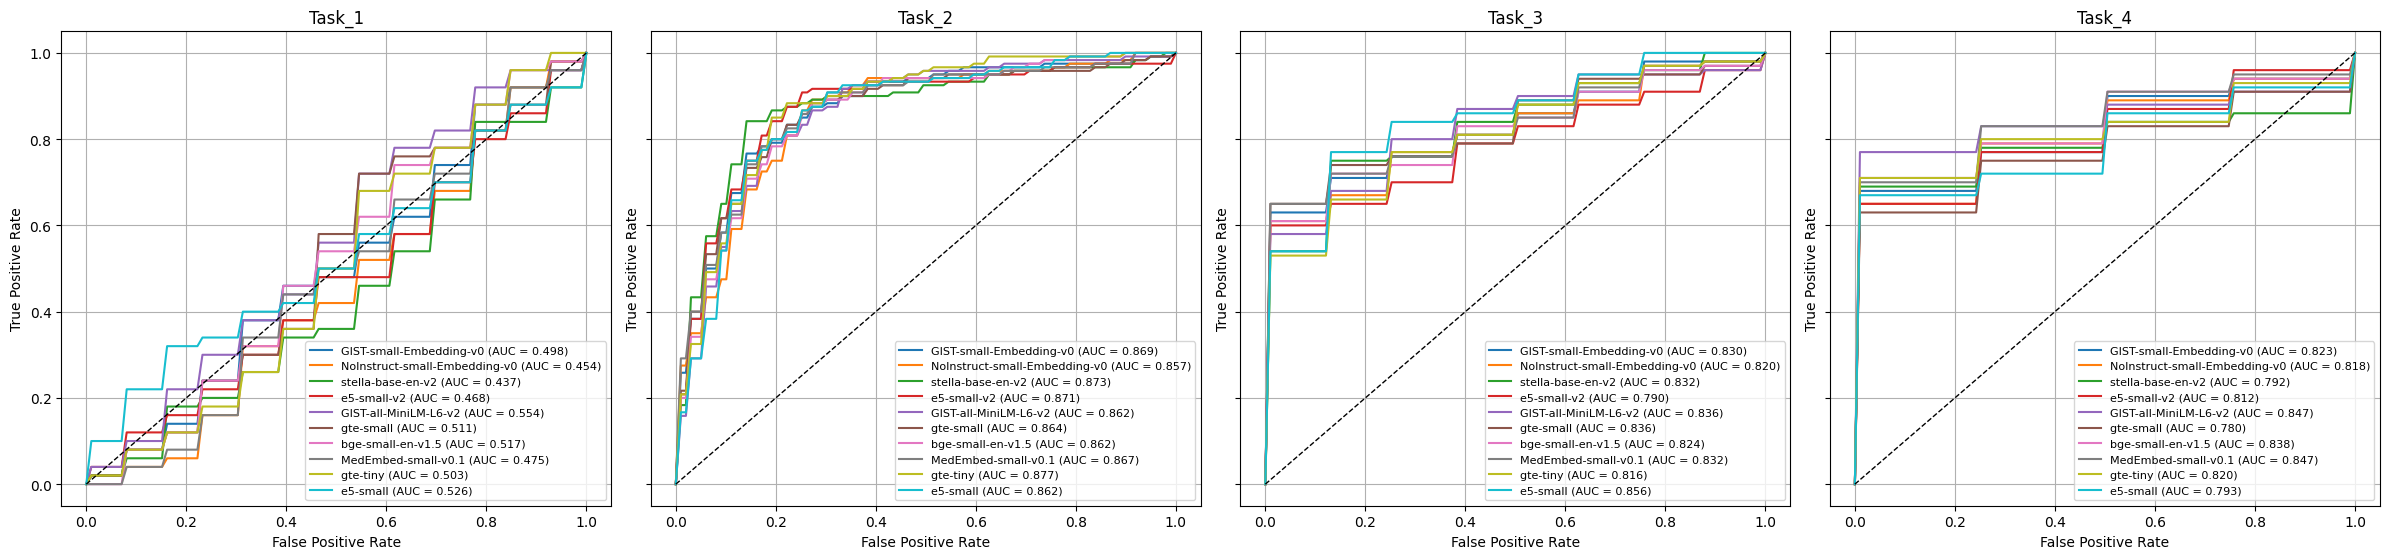

In [3]:
# Common FPR grid for interpolation
fpr_common = np.linspace(0, 1, 100)

# Sorted list of tasks
tasks_sorted = sorted(all_model_runs.keys())
n_tasks = len(tasks_sorted)

# Set up 1 row, N columns (N = number of tasks)
fig, axes = plt.subplots(1, n_tasks, figsize=(6 * n_tasks, 6), sharex=True, sharey=True)
if n_tasks == 1:
    axes = [axes]  # make iterable

# Loop over tasks
for i_task, task in enumerate(tasks_sorted):
    ax = axes[i_task]
    model_runs = all_model_runs[task]  # model_name -> list of runs

    for model_name, runs in model_runs.items():
        tpr_interp_all = []
        auc_all = []

        for run in runs:
            fpr = np.array(run['fpr'][1])
            tpr = np.array(run["tpr"][1])

            # Validate FPR and TPR
            if fpr.ndim != 1 or tpr.ndim != 1 or len(fpr) == 0 or len(tpr) == 0 or len(fpr) != len(tpr):
                print(f"Skipping invalid run for model {model_name}, task {task}")
                continue

            # Interpolate
            interp_tpr = np.interp(fpr_common, fpr, tpr)
            interp_tpr[0] = 0.0
            tpr_interp_all.append(interp_tpr)
            auc_all.append(auc(fpr, tpr))

        # Skip model if no valid runs
        if not tpr_interp_all:
            continue

        mean_tpr = np.mean(tpr_interp_all, axis=0)
        mean_auc = np.mean(auc_all)
        ax.plot(fpr_common, mean_tpr, label=f"{model_name} (AUC = {mean_auc:.3f})")

    # Plot settings for this subplot
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title(task, fontsize=12)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.grid(True)
    ax.legend(fontsize=8, loc="lower right", ncol=1)
# Finalize layout and save
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"./res/2025_0606_AUCPlots/{fig_num}_finetune_{embed_type}_roc_curve.pdf", format="pdf", bbox_inches="tight")
plt.show()